# MLB Postseason Umpire Analysis

For this project, we wanted to study the accuracy of the umpires who called the 2018 MLB Postseason games.  In this project, we focused on three main questions.
* [Overall, how accurate are the umpires?](#Question-1:-How-accurate-are-the-umpires?)
* [Do player attributes influence the accuracy of the umpire?](#Question-2:-Do-Players-Influence-the-Accuracy-of-the-Umpire?)
* [Does the environment influence the accuracy of the umpire?](#Question-3:-Does-the-Environment-Influence-the-Accuracy-of-the-Umpire?)
* If you want, skip to our [conclusion](#Conclusions).

In [27]:
# Load all necessary dependencies
import time
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from scipy import stats

from config import api_key
%matplotlib inline

The data was retrieved from the [sportradar](https://developer.sportradar.com/) MLB API. There were three steps in data retrieval.
1. Obtain list of all game IDs for the 2018 postseason.
2. Check to see if game was played and had valid pitch location data (some games were not played due to series ending).
3. For all games that have data:
    * Retrieve the umpire name from the game summary API endpoint
    * Retrieve all called pitches along with relevant data from play by play API endpoint

In [4]:
# Build list of postseason games
base_url = 'http://api.sportradar.us/mlb/trial/v6.5/en/games/{}/{}.json?api_key={}'
schedule_url = base_url.format('2018/PST', 'schedule', api_key)

resp = requests.get(schedule_url).json()
postseason_games = [x['id'] for x in resp['games']]
postseason_games

['000023f8-e153-4dcd-9ba0-627ecc9f162e',
 '09e05863-db41-4346-b007-c58201655f9a',
 '0a408f5b-3ea6-4500-84d4-d01a56b3f3c2',
 '0af06a7c-55e9-49e2-bf18-ba91e87f112f',
 '0c29784b-96cf-478c-b2b4-5dc59c4dac2f',
 '0dc994a5-3fe9-419d-a6dd-0727c01c38ef',
 '2a747bb0-2213-4db6-8173-14a8a1060c36',
 '2aee13d3-9bbe-4e51-a6a7-22fdb01f6fb3',
 '37d6d617-2b4a-4c81-b257-504bbf6793ed',
 '3919001f-caa4-4d5f-9087-dbf5dfb23542',
 '3caab0f7-253b-4bde-bf45-9e0838fc2118',
 '472ad042-b1e0-4a15-93ee-34297fcfeb2d',
 '4aaf2a8a-cab1-4085-b011-fe555e723193',
 '4ecec54e-d51b-483d-831d-a2c535d6e8fa',
 '560f46cd-679d-4bf6-93bb-74b322d33c17',
 '5b58eaf5-792a-4c9f-9c83-39094d8b566e',
 '5d1f85bd-4f87-47cc-9975-52dedd2302cc',
 '5da8f654-17ad-4664-a043-02a6f3b5e23d',
 '6721b2fd-829c-472a-bb23-026068987859',
 '6b10edd9-8a3f-4e5e-bcc5-e65de6c68cff',
 '6b7e96c5-b7ee-449d-8756-cbb25b2ce636',
 '7a524055-608d-45f4-9219-2e6b3ad47a0b',
 '838f51b1-8fa9-4742-ad1c-db05ef23f9a5',
 '84d375dc-ec1e-4bb5-9260-c018c820dad4',
 '86a0958a-2b1b-

In [6]:
# Retrieve names of home plate umpires and corresponding game IDs
def get_umpire(game_id, api_key):
    umpire_url = base_url.format(game_id, 'summary', api_key)
    resp = requests.get(umpire_url).json()
    officials = resp['game']['officials']
    for official in officials:
        if official['assignment'] == 'HP':
            return official['full_name']


# Retrieve play-by-play data by game ID
def get_game_by_id(game_id, api_key):
    game_url = base_url.format(game_id, 'pbp', api_key)
    game_resp = requests.get(game_url).json()
    return game_resp

In [5]:
# Validate presence of pitch location data
games = list()

i = 0
k = 0

for game in postseason_games:
    try:
        k += 1
        time.sleep(1.1)
        game_resp = get_game_by_id(game)
        if 'pitch_x' in game_resp['game']['innings'][1]['halfs'][0]['events'][0]['at_bat']['events'][0]['pitcher'].keys():
            games.append(game)
            i += 1
        print(f'{i}/{k}')
    except:
        print(f'{i}/{k}')

1/1
1/2
2/3
3/4
4/5
5/6
6/7
6/8
7/9
7/10
8/11
9/12
10/13
10/14
11/15
12/16
13/17
13/18
14/19
15/20
16/21
17/22
18/23
19/24
20/25
21/26
22/27
23/28
23/29
24/30
24/31
25/32
26/33
26/34
26/35
27/36
28/37
28/38
29/39
30/40
31/41
32/42
33/43


Now that we have compiled a list of all games, we can collect all of the play-by-play data to retrieve the following metrics and append them to a CSV file:
* Umpire
* Game ID
* Home or Away team at bat
* What the call was (ball or strike)
* Pitch X (horizontal) and Y (vertical) location
    * These are relative numbers, meaning that +-100 is the edge of the strikezone
* Pitcher hand
* Batter hand
* Pitch type
* Pitch speed

In [7]:
# Traverse the JSON response to collect all relevant play-by-play data
# These codes correspond to pitches that were called ball or strike by the umpire
outcome_ids = ['kKL', 'bB', 'aKLAD1', 'aKLAD2', 'aKLAD3', 'aKLAD4', 'oKLT1', 'oKLT2', 'oKLT3',
               'oKLT4']
csv_header = ['Umpire', 'Game_ID', 'Home/Away', 'Called Ball/Strike', 'Pitch_X', 'Pitch_Y',
              'Pitcher_Hand', 'Batter_Hand', 'Pitch_Type', 'Pitch_Speed']

with open('Resources/pitch_data.csv', 'w', newline='') as fout:
    csvwriter = csv.writer(fout, delimiter=',')
    csvwriter.writerow(csv_header)
    for game in games:
        time.sleep(1.1)
        game_json = get_game_by_id(game, api_key)
        time.sleep(1.1)
        umpire = get_umpire(game, api_key)
        for inning in game_json['game']['innings'][1:]:
            for half in inning['halfs']:
                t_b = half['half']
                if t_b == 'T':
                    t_b = 'Away'
                else:
                    t_b = 'Home'
                for event in half['events']:
                    try:
                        for pitch in event['at_bat']['events']:
                            if pitch['outcome_id'] in outcome_ids:
                                if pitch['outcome_id'] == 'bB':
                                    call = 'Ball'
                                else:
                                    call = 'Strike'
                                pitch_type = pitch['pitcher']['pitch_type']
                                pitch_speed = pitch['pitcher']['pitch_speed']
                                pitcher_hand = pitch['pitcher']['pitcher_hand']
                                batter_hand = pitch['pitcher']['hitter_hand']
                                pitch_x = pitch['pitcher']['pitch_x']
                                pitch_y = pitch['pitcher']['pitch_y']
                                csvwriter.writerow([umpire, game, t_b, call, pitch_x, pitch_y,
                                                    pitcher_hand, batter_hand, pitch_type,
                                                    pitch_speed])
                    except:
                        pass

print('done')

done


Now that all of the data was collected from the API and stored into a CSV file, it can be manipulated using pandas and visualized with matplotlib.

In [6]:
pitch_df = pd.read_csv('Resources/pitch_data.csv')
pitch_df.head()

,Umpire,Game_ID,Home/Away,Called Ball/Strike,Pitch_X,Pitch_Y,Pitcher_Hand,Batter_Hand,Pitch_Type,Pitch_Speed
0,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Ball,-170,-47,L,R,FA,91.0
1,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Strike,82,-21,L,R,FA,89.0
2,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Ball,41,152,L,R,FA,90.0
3,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Ball,-88,143,L,R,FA,94.0
4,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Ball,-200,-34,L,R,FA,93.0


In [7]:
# Append dataframe with column for True/False for accuracy of umpire call
pitch_dictionary = {'FA': 'Fastball',
                    'SI': 'Sinker',
                    'CT': 'Cutter',
                    'CU': 'Curveball',
                    'SL': 'Slider',
                    'CH': 'Changeup',
                    'KN': 'Knuckleball',
                    'SP': 'Splitter',
                    'SC': 'Screwball',
                    'FO': 'Forkball',
                    'IB': 'Intentional Ball',
                    'PI': 'Pitchout', }

pitch_df['Theoretical_Call'] = ''
pitch_df['Accurate'] = ''
pitch_df['Strike'] = ''

for i, row in pitch_df.iterrows():
    pitch_x = abs(row['Pitch_X'])
    pitch_y = abs(row['Pitch_Y'])
    pitch_type = row['Pitch_Type']
    pitch_df.loc[i, 'Pitch_Type'] = pitch_dictionary.get(pitch_type, 'NA')
    if (pitch_x > 100) or (pitch_y > 100):
        pitch_df.loc[i, 'Theoretical_Call'] = 'Ball'
        pitch_df.loc[i, 'Strike'] = False
    else:
        pitch_df.loc[i, 'Theoretical_Call'] = 'Strike'
        pitch_df.loc[i, 'Strike'] = True
    if pitch_df.loc[i, 'Called Ball/Strike'] == pitch_df.loc[i, 'Theoretical_Call']:
        pitch_df.loc[i, 'Accurate'] = True
    else:
        pitch_df.loc[i, 'Accurate'] = False

pitch_df.head()

,Umpire,Game_ID,Home/Away,Called Ball/Strike,Pitch_X,Pitch_Y,Pitcher_Hand,Batter_Hand,Pitch_Type,Pitch_Speed,Theoretical_Call,Accurate,Strike
0,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Ball,-170,-47,L,R,Fastball,91.0,Ball,True,False
1,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Strike,82,-21,L,R,Fastball,89.0,Strike,True,True
2,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Ball,41,152,L,R,Fastball,90.0,Ball,True,False
3,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Ball,-88,143,L,R,Fastball,94.0,Ball,True,False
4,James Hoye,000023f8-e153-4dcd-9ba0-627ecc9f162e,Away,Ball,-200,-34,L,R,Fastball,93.0,Ball,True,False


## Question 1: How accurate are the umpires?

The first question is about overall accuracy of the umpires. Since all of the data collected was on called balls and strikes, we can compare the pitch location (and subsequent theoretical call) to what was actually called.

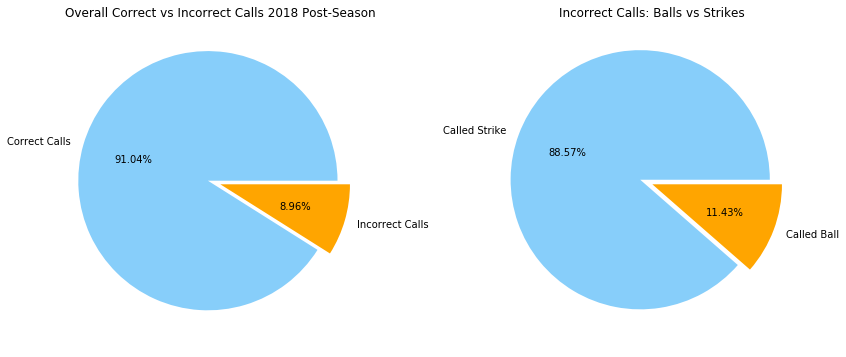

<Figure size 1440x720 with 0 Axes>

In [8]:
acc_data = pitch_df["Accurate"].value_counts()
incrt_df = pitch_df.loc[pitch_df['Accurate'] == 0]
incrt_data = incrt_df['Called Ball/Strike'].value_counts()

explode = [0.1, 0]
colors = ["lightskyblue", "orange"]
labels = ["Correct Calls", "Incorrect Calls"]
incrt_labels = ["Called Strike", "Called Ball"]

fig = plt.figure()
ax1 = fig.add_axes([0, 0, 0.75, 1.5], aspect=1)
ax1.pie(acc_data, explode=explode, labels=labels,
        autopct='%0.2f%%', colors=colors)
ax2 = fig.add_axes([1, .0, 0.75, 1.5], aspect=1)
ax2.pie(incrt_data, explode=explode, labels=incrt_labels,
        autopct='%0.2f%%', colors=colors)
ax1.set_title("Overall Correct vs Incorrect Calls 2018 Post-Season")
ax2.set_title("Incorrect Calls: Balls vs Strikes")

plt.figure(figsize=(20, 10))
plt.tight_layout()

fig.savefig("Images/dbl_pie_incorrect_calls.png", bbox_inches="tight")
plt.show()

From the graph above, we can see that on all called pitches in the 2018 MLB Postseason, 91% were correct. What is interesting, however, is that the 9% of missed calls are overwhelmingly called strikes (89%).

In [9]:
# Group pitch data by umpire for a more granular analysis of umpire performance
umpire_group = pitch_df.groupby('Umpire')
incrt_umpire_group = incrt_df.groupby('Umpire')

total_calls = umpire_group['Called Ball/Strike'].count()
missed_calls = incrt_umpire_group['Accurate'].count()

ump_calls_df = pd.DataFrame({"Total Calls": total_calls,
                             "Missed Calls": missed_calls,
                             "Missed Call Percentage": missed_calls / total_calls, })

ump_calls_df['Umpire'] = ump_calls_df.index
ump_calls_df = ump_calls_df.sort_values(
    by=["Missed Call Percentage"], ascending=False)

ump_calls_df.head()

,Total Calls,Missed Calls,Missed Call Percentage,Umpire
Umpire,,,,
Kerwin Danley,232,33,0.142241,Kerwin Danley
Cory Blaser,147,19,0.129252,Cory Blaser
Chris Guccione,308,39,0.126623,Chris Guccione
Vic Carapazza,132,16,0.121212,Vic Carapazza
Lance Barksdale,94,11,0.117021,Lance Barksdale


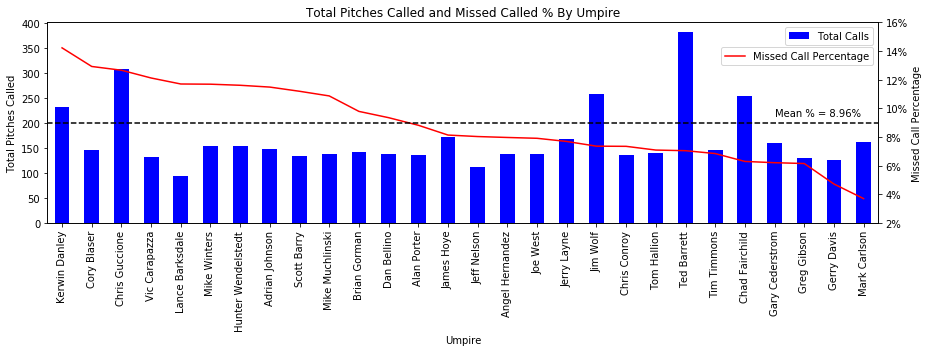

In [10]:
# Construct plot of individual umpire total calls and percent missed for the 33 post-season games
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ump_calls_df.plot(kind='bar', x='Umpire', y='Total Calls', ax=ax1, color='blue',
                  legend=True).legend(bbox_to_anchor=(1, 1))
ump_calls_df['Missed Call Percentage'].plot(ax=ax2, color='red',
                                            legend=True).legend(bbox_to_anchor=(1, 0.9))

plt.title('Total Pitches Called and Missed Called % By Umpire')
plt.xlabel('Umpire')
ax1.set_ylabel('Total Pitches Called')
ax2.set_ylabel('Missed Call Percentage')

mean_line = pitch_df["Accurate"].mean() * 100
mean_line_round = round(mean_line, 4)
incrt_mean = (1 - (mean_line_round/100))
plt.axhline(y=incrt_mean, color="black", ls="dashed")
plt.text(24, incrt_mean+0.005, (f'Mean % = {incrt_mean*100:.2f}%'))

vals = ax2.get_yticks()
frmt = ['{:.0f}%'.format(val*100) for val in vals]
ax2.set_yticks(vals)
ax2.set_yticklabels(frmt)

plt.tight_layout()

fig.savefig("Images/calls_by_ump.png")
plt.show()

From this chart we see that the mean percentage of missed calls is 8.96%, but the range is anywhere from ~14% to ~4%. There does not seem to be a correlation between total calls and the accuracy.

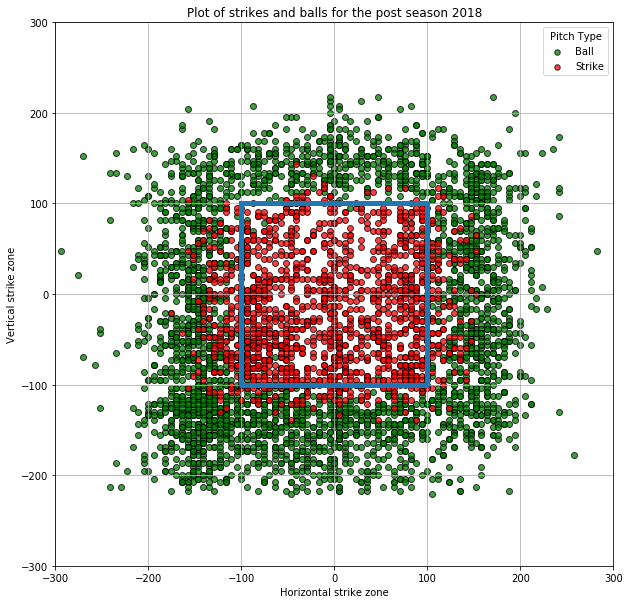

In [11]:
# Construct scatter of all called pitches on the x/y axis.  Red denotes a called strike and green denotes a called ball.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

strikes = pitch_df.loc[pitch_df["Called Ball/Strike"] == "Strike"]
balls = pitch_df.loc[pitch_df["Called Ball/Strike"] == "Ball"]

x_axis_b = balls["Pitch_X"]
y_axis_b = balls["Pitch_Y"]
x_axis_s = strikes["Pitch_X"]
y_axis_s = strikes["Pitch_Y"]

plt.figure()
plt.scatter(x_axis_b, y_axis_b, marker="o",
            facecolors="green", edgecolors="black", alpha=0.75)
plt.scatter(x_axis_s, y_axis_s, marker="o",
            facecolors="red", edgecolors="black", alpha=0.75)
plt.grid()
plt.title("Plot of strikes and balls for the post season 2018")
plt.xlabel("Horizontal strike zone")
plt.ylabel("Vertical strike zone")
plt.ylim(-300, 300)
plt.xlim(-300, 300)

lgnd = plt.legend(["Ball", "Strike"], loc=1,
                  markerscale=.5, title="Pitch Type")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

x = [-100, -100, 100, 100, -100]
y = [100, -100, -100, 100, 100]
plt.plot(x, y, linewidth=5)

fig.savefig("Images/all_pitches_scatter.png", bbox_inches="tight")
plt.show()

Above is a scatter plot of all of the called pitches in the dataset. The called strike zone appears to be larger than the theoretical stike zone.

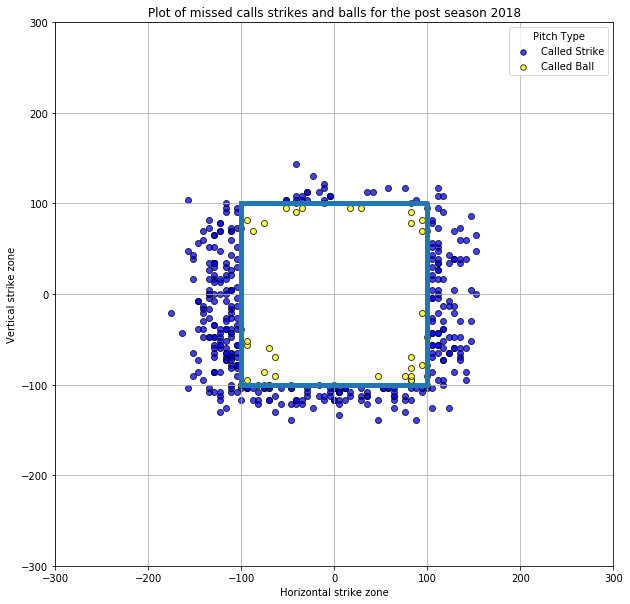

In [12]:
# Construct a plot similar to the one above, but showing only the missed calls
strikes_bad = strikes.loc[strikes['Accurate'] == False]
balls_bad = balls.loc[balls['Accurate'] == False]

x_axis_strikes_bad = strikes_bad["Pitch_X"]
y_axis_strikes_bad = strikes_bad["Pitch_Y"]
x_axis_balls_bad = balls_bad["Pitch_X"]
y_axis_balls_bad = balls_bad["Pitch_Y"]


temp_plot = plt.scatter(x_axis_strikes_bad, y_axis_strikes_bad, marker="o",
                        facecolors="blue", edgecolors="black", alpha=0.75)
temp_plot = plt.scatter(x_axis_balls_bad, y_axis_balls_bad, marker="o",
                        facecolors="yellow", edgecolors="black", alpha=0.75)

plt.grid()

plt.title("Plot of missed calls strikes and balls for the post season 2018")
plt.xlabel("Horizontal strike zone")
plt.ylabel("Vertical strike zone")

lgnd = plt.legend(["Called Strike", "Called Ball"], loc=1,
                  markerscale=.5, title="Pitch Type")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

plt.plot(x, y, linewidth=5)

plt.ylim(-300, 300)
plt.xlim(-300, 300)

plt.savefig("Images/missed_calls_strikes_balls.png", bbox_inches="tight")
plt.show()

This graph shows the missed calls. Clearly, the umpires are aggressive and call a much larger srike zone relative to the theoretical. As noted before, the overwhelming majority of missed calls are called strike when, technically, they fell outside the strike zone.

* The umpires are fairly accurate with an accuracy score of 91% on ~4,700 called pitches.
* Accuracy and total called balls did not seem to have a strong relationship.
* Umpires tend to call aggressively, meaning they are more likely to call a theoretical ball a strike than a theoretical strike a ball.

## Question 2: Do Players Influence the Accuracy of the Umpire?

Next, we wanted to explore whether players can influence the accuracy of the umpire.  We hypothesized that pitch type and speed would have the largest player-controlled influence on the accuracy of an umpire's call.

In [13]:
# Bin the pitch speeds into groups of 5 mph starting at 65 mph and construct a dataframe
# with relevant columns
bins = (65, 70, 75, 80, 85, 90, 95, 100, 105)
group_names = ("65-70", "71-75", "76-80", "81-85",
               "86-90", "91-95", "95-100", "101+")
pitch_df["Speed Bin"] = pd.cut(
    pitch_df.loc[:, "Pitch_Speed"], bins, labels=group_names)
incrt_df["Speed Bin"] = pd.cut(
    pitch_df.loc[:, "Pitch_Speed"], bins, labels=group_names)

total_calls = pitch_df.groupby('Speed Bin')['Called Ball/Strike'].count()
missed_calls = incrt_df.groupby('Speed Bin')['Accurate'].count()

pitch_speed_df = pd. DataFrame({"Total Calls": total_calls,
                                "Incorrect Calls": missed_calls,
                                "Incorrect %": missed_calls / total_calls, })
pitch_speed_df.fillna(0, inplace=True)

pitch_speed_df['Pitch Speed (MPH)'] = pitch_speed_df.index

pitch_speed_df

/Users/RunforrrestruN/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Total Calls,Incorrect Calls,Incorrect %,Pitch Speed (MPH)
Speed Bin,,,,
65-70,8,1,0.125000,65-70
71-75,134,19,0.141791,71-75
76-80,288,28,0.097222,76-80
81-85,640,48,0.075000,81-85
86-90,1175,102,0.086809,86-90
91-95,1470,151,0.102721,91-95
95-100,964,70,0.072614,95-100
101+,8,1,0.125000,101+


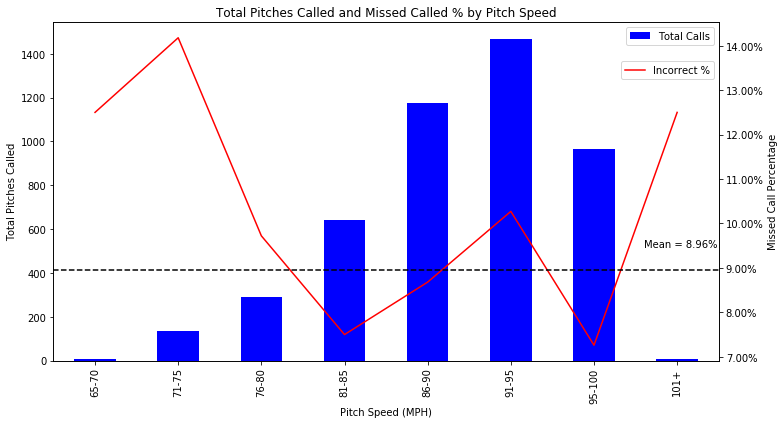

In [14]:
# Construct a plot of total pitches for the bins, and overlay the missed call percentage
# for that bin
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 11
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

pitch_speed_df.plot(kind='bar', x='Pitch Speed (MPH)', y='Total Calls', ax=ax1,
                    color='blue', legend=True).legend(bbox_to_anchor=(1, 1))
pitch_speed_df['Incorrect %'].plot(ax=ax2, color='red',
                                   legend=True).legend(bbox_to_anchor=(1, 0.9))

plt.title('Total Pitches Called and Missed Called % by Pitch Speed')
plt.xlabel('Pitch Speed (MPH)')
ax1.set_ylabel('Total Pitches Called')
ax2.set_ylabel('Missed Call Percentage')

incrt_mean = 1 - (mean_line_round/100)
plt.axhline(y=incrt_mean, color="black", ls="dashed")
plt.text(6.6, incrt_mean+0.005, (f'Mean = {incrt_mean*100:.2f}%'))

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.tight_layout()

fig.savefig('Images/calls_pitch_speed.png')
plt.show()

The pitch speed appears to be a skewed gaussian distribution, but this includes all pitch types. The slower pitches and fastest pitch groups had the highest inaccuracy, but had fewer overall pitches. From this visual, we hypothesized the relatively low call accuracy of the slowest pitches was a result of the pitch type (curve, slider, etc.) often associated with a lower relative speed.  Thus, it may not be speed itself but the movement of certain pitches found within this bin (those moving vertically or horizontally during the pitch). This can give the illusion the ball crossed an area of the plate within the strike zone, when in actuality, it did not. 

In [15]:
# Construct dataframe of missed calls percent by pitch type
total_calls = pitch_df.groupby('Pitch_Type')['Called Ball/Strike'].count()
missed_calls = incrt_df.groupby('Pitch_Type')['Accurate'].count()

pitch_type_df = pd.DataFrame({"Total Calls": total_calls,
                              "Missed Calls": missed_calls,
                              "Missed Call %": missed_calls / total_calls, })

pitch_type_df['Pitch Type'] = pitch_type_df.index
pitch_type_df = pitch_type_df.sort_values(
    by=["Missed Call %"], ascending=False)

pitch_type_df

,Total Calls,Missed Calls,Missed Call %,Pitch Type
Pitch_Type,,,,
Cutter,422,49,0.116114,Cutter
Sinker,184,19,0.103261,Sinker
Changeup,318,29,0.091195,Changeup
Fastball,2366,206,0.087067,Fastball
Curveball,659,57,0.086495,Curveball
Slider,686,58,0.084548,Slider
Splitter,53,2,0.037736,Splitter


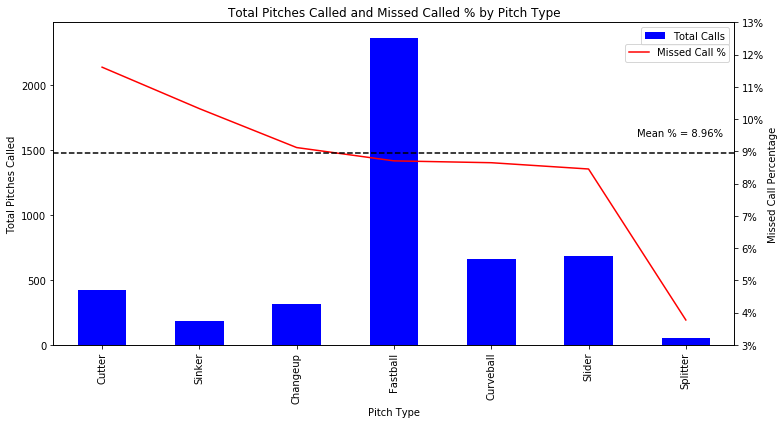

In [16]:
# Consruct similar plot to previous, except by type of pitch
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

pitch_type_df.plot(kind='bar', x='Pitch Type', y='Total Calls', ax=ax1, color='blue',
                   legend=True).legend(bbox_to_anchor=(1, 1))
pitch_type_df['Missed Call %'].plot(ax=ax2, color='red',
                                    legend=True).legend(bbox_to_anchor=(1, 0.95))

plt.title('Total Pitches Called and Missed Called % by Pitch Type')
plt.xlabel('Pitch Type')
ax1.set_ylabel('Total Pitches Called')
ax2.set_ylabel('Missed Call Percentage')

incrt_mean = 1 - (mean_line_round/100)
ax2.axhline(y=incrt_mean, color="black", ls="dashed")
plt.text(5.5, incrt_mean+0.005, (f'Mean % = {incrt_mean*100:.2f}%'))

vals = ax2.get_yticks()
frmt = ['{:.0f}%'.format(val*100) for val in vals]
ax2.set_yticks(vals)
ax2.set_yticklabels(frmt)

plt.tight_layout()

fig.savefig('Images/calls_pitch_type.png')
plt.show()

The cutter, sinker, and changeup were all above average for inaccuracy. The cutter had the highest innacuracy percent, at ~12%,  The cutter combines speed and movement which might make it more difficult to call accurately.  The umpires were very accurate on the splitter, which is impressive because it had the least amount of pitches.  However, it could be that the data set is too low for an accurate assessment.

We initially hypothesized that the pitch speed and pitch type would have an influence on the umpire's accuracy. It did seem that some pitch types were easier to call for the umpires than others, but the amount of movement alone did not necessarily change the umpires ability to call the pitch accurately.

## Question 3: Does the Environment Influence the Accuracy of the Umpire?

We have all heard about "home cookin'". If your team is on the road, the umpires just cannot get a call right! We wanted to dive into this and see if what we all know to be true actually is. We hypothesized that the umpires would be better for the home team than the away team.

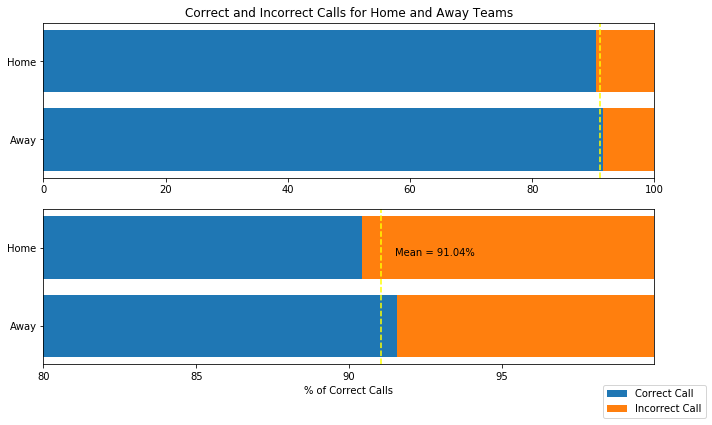

In [26]:
# Extract data on home and away accuracy of calls and construct stacked bar chart of
# accurate and innacurate percentage
home_inc = len(incrt_df.loc[incrt_df["Home/Away"] == "Home"])
correct_df = pitch_df.loc[pitch_df["Accurate"] == True]
home_crt = len(correct_df.loc[correct_df["Home/Away"] == "Home"])
home_crt_percent = home_crt / (home_inc + home_crt) * 100
home_inc_percent = (100 - home_crt_percent)

away_inc = len(incrt_df.loc[incrt_df["Home/Away"] == "Away"])
away_crt = len(correct_df.loc[correct_df["Home/Away"] == "Away"])
away_crt_percent = away_crt / (away_crt + away_inc) * 100
away_inc_percent = (100 - away_crt_percent)

correct_calls = [away_crt_percent, home_crt_percent]
incorrect_calls = [away_inc_percent, home_inc_percent]

mean_line = pitch_df["Accurate"].mean() * 100
mean_line_round = round(mean_line, 4)

fig = plt.figure()
N = 2

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

ind = np.arange(N)
plt.subplot(2, 1, 1)
p1 = plt.barh(ind, correct_calls)
p2 = plt.barh(ind, incorrect_calls, left=correct_calls)

plt.xlabel("")
plt.yticks(ind, ("Away", "Home"))
plt.xlim(0, 100)
plt.title("Correct and Incorrect Calls for Home and Away Teams")

plt.axvline(x=mean_line_round, color="yellow", ls="dashed")
plt.subplot(2, 1, 2)
p1 = plt.barh(ind, correct_calls)
p2 = plt.barh(ind, incorrect_calls, left=correct_calls)

plt.xlabel("% of Correct Calls")
plt.yticks(ind, ("Away", "Home"))
plt.xticks(np.arange(80, 100, 5))
plt.xlim(80, 100)
plt.legend((p1[0], p2[0]), ('Correct Call', 'Incorrect Call'),
           loc=9, bbox_to_anchor=(1, -0.1))

plt.axvline(x=mean_line_round, color="yellow", ls="dashed")
plt.text(91.5, 0.9, (f"Mean = {mean_line_round:.2f}%"))

plt.tight_layout()
fig.savefig("Images/home_away_calls.png")
plt.show()

Suprisingly, the umpires are more inaccurate when the home team is at bat. While the difference is only about 2%, we hypothesized that the away team would have a tougher time, and 2% can be enough of a boost to win or lose a very close game.

In [18]:
# Construct dataframe of accuracy for home and away for each individual umpire
total_aways = pitch_df.loc[pitch_df['Home/Away']
                           == 'Away'].groupby('Umpire')['Pitch_X'].count()
missed_calls = pitch_df.loc[pitch_df['Accurate'] == False]
missed_aways = missed_calls.loc[missed_calls['Home/Away']
                                == 'Away'].groupby('Umpire')['Accurate'].count()
missed_homes = missed_calls.loc[missed_calls['Home/Away']
                                == 'Home'].groupby('Umpire')['Accurate'].count()
all_pitches = pitch_df.groupby('Umpire')['Game_ID'].count()

all_data = pd.DataFrame({'Game_ID': all_pitches,
                         'Missed_Away': missed_aways,
                         'Missed_Home': missed_homes,
                         'Total Aways': total_aways, })

all_data['Total Homes'] = all_data['Game_ID'] - all_data['Total Aways']
all_data['% Missed Home'] = all_data['Missed_Home'] / all_data['Total Homes']
all_data['% Missed Away'] = all_data['Missed_Away'] / all_data['Total Aways']
all_data['Home/Away Delta'] = (all_data['% Missed Home'] -
                               all_data['% Missed Away']) * 100

all_data.head()

,Game_ID,Missed_Away,Missed_Home,Total Aways,Total Homes,% Missed Home,% Missed Away,Home/Away Delta
Umpire,,,,,,,,
Adrian Johnson,148,6,11,67,81,0.135802,0.089552,4.625023
Alan Porter,136,7,5,73,63,0.079365,0.095890,-1.652533
Angel Hernandez,138,8,3,79,59,0.050847,0.101266,-5.041837
Brian Gorman,143,6,8,80,63,0.126984,0.075000,5.198413
Chad Fairchild,254,6,10,125,129,0.077519,0.048000,2.951938


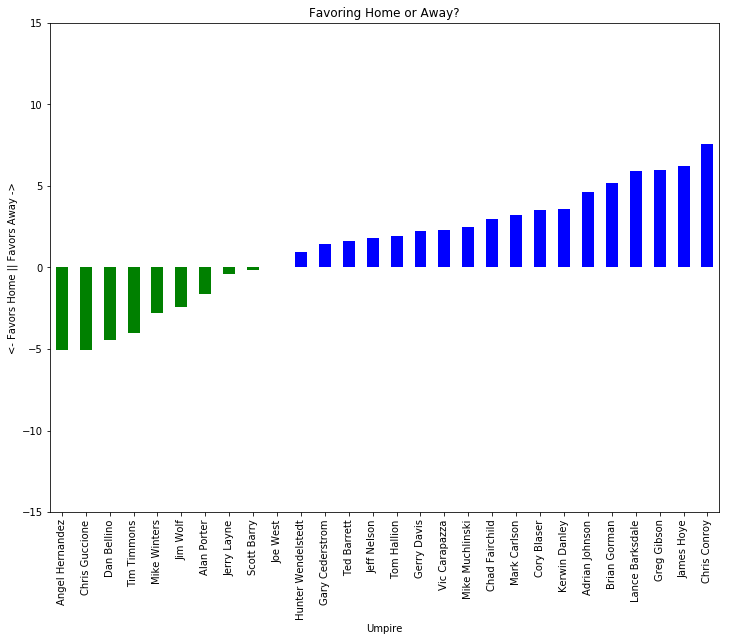

In [19]:
# Consruct plot of difference between home and away missed calls for each umpire.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

all_data = all_data.sort_values('Home/Away Delta')

bar_colors = list()
for number in all_data['Home/Away Delta']:
    if number <= 0:
        bar_colors.append('g')
    else:
        bar_colors.append('b')

all_data['Home/Away Delta'].plot(kind='bar', align='center', color=bar_colors)
plt.ylabel('<- Favors Home || Favors Away ->')
plt.title('Favoring Home or Away?')
plt.margins(0.02)
plt.ylim(-15, 15)

plt.savefig('Images/favor_home_or_away.png')
plt.show()

In the figure before this one, we saw that the umpires were less accurate when the home team was at bat. Because most of the inaccuracies are called strikes when they should be balls, we decided that we would classify a missed call as detrimental to the team at the plate. As we can see in the figure above, there are more umpires who call pro-away and the pro-away umps seem to be more polarized than the pro-home. Maybe heckling the umpire isn't such a good idea!

The other environmental factor is the batter hand. Since the batter sets up in a different location based on their handedness, this changes what the umpire sees and we hypothesize that it changes the location of the pitches (anecdotally, we know this to be true).

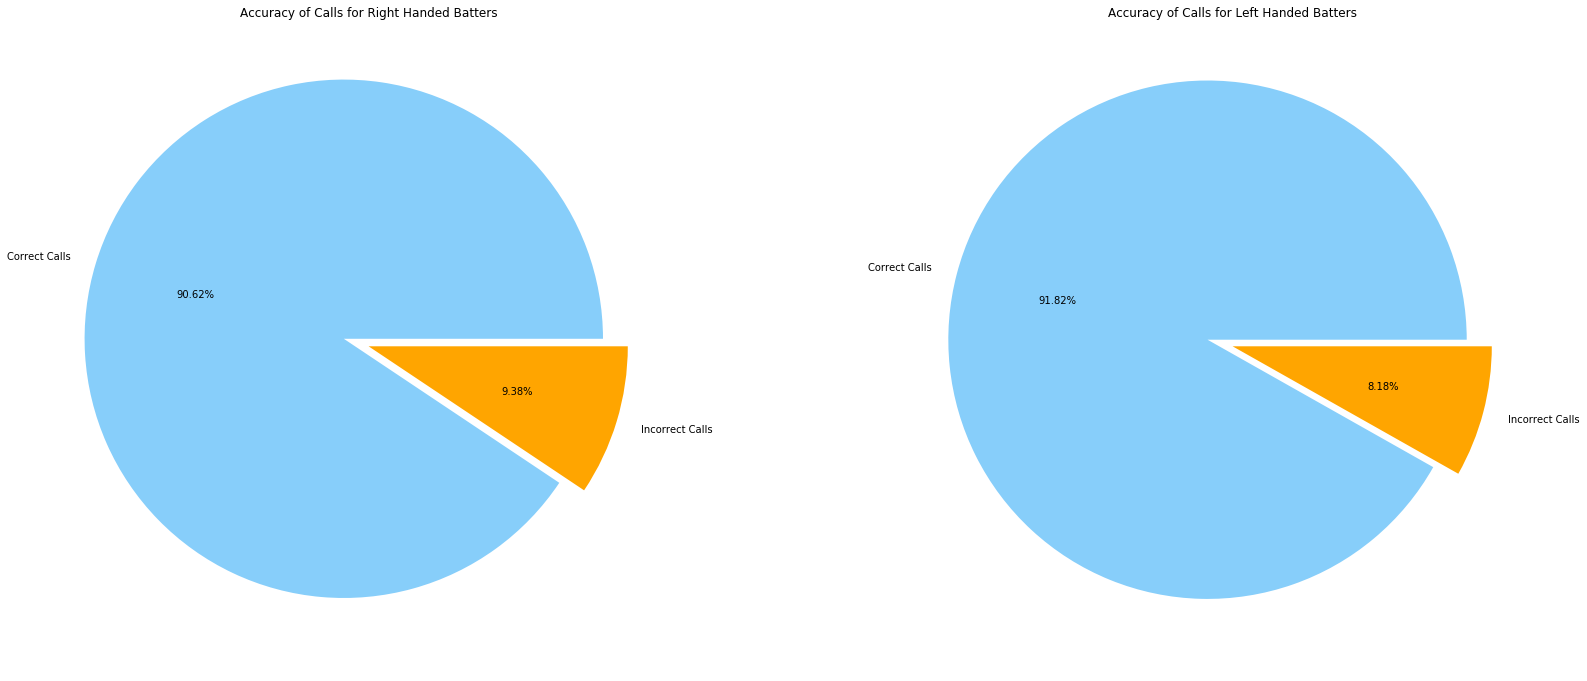

<Figure size 1440x720 with 0 Axes>

In [20]:
# Construct dataframes and pie charts of accuracy/inaccuracy as a function of batter handedness
rh_df = pitch_df.loc[pitch_df["Batter_Hand"] == "R"]
lh_df = pitch_df.loc[pitch_df["Batter_Hand"] == "L"]

rh_data = rh_df["Accurate"].value_counts()
lh_data = lh_df["Accurate"].value_counts()

hand_labels = ["Correct Calls", "Incorrect Calls"]

fig = plt.figure()
ax1 = fig.add_axes([0, 0, 0.75, 1.5], aspect=1)
ax1.pie(rh_data, explode=explode, labels=hand_labels,
        autopct='%0.2f%%', colors=colors)
ax2 = fig.add_axes([1, .0, 0.75, 1.5], aspect=1)
ax2.pie(lh_data, explode=explode, labels=hand_labels,
        autopct='%0.2f%%', colors=colors)

ax1.set_title("Accuracy of Calls for Right Handed Batters")
ax2.set_title("Accuracy of Calls for Left Handed Batters")

plt.figure(figsize=(20, 10))
plt.tight_layout()

fig.savefig("Images/dbl_pie_right_left.png", bbox_inches="tight")
plt.show()

The umpires were more accurate for left handed batters by about 1.2%.

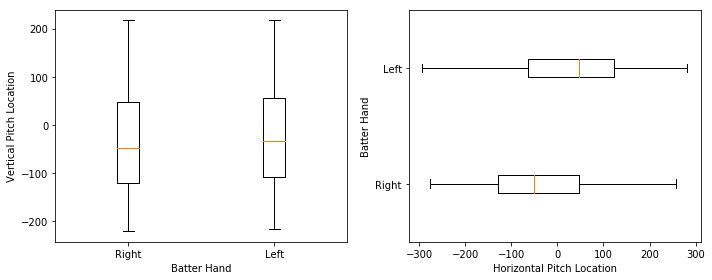

In [21]:
# Construct box and whiskers showing the vertical and horizontal distribution of pitches
# for left and right-handed batters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

right_hand_x = pitch_df[pitch_df['Batter_Hand'] == 'R']['Pitch_X']
right_hand_y = pitch_df[pitch_df['Batter_Hand'] == 'R']['Pitch_Y']
left_hand_x = pitch_df[pitch_df['Batter_Hand'] == 'L']['Pitch_X']
left_hand_y = pitch_df[pitch_df['Batter_Hand'] == 'L']['Pitch_Y']

fig = plt.figure()
axes = fig.add_subplot(121)
plt.boxplot([right_hand_y, left_hand_y])
axes.set_xticklabels(['Right', 'Left'])
plt.ylabel('Vertical Pitch Location')
plt.xlabel('Batter Hand')
axes = fig.add_subplot(122)
plt.boxplot([right_hand_x, left_hand_x], vert=False)
axes.set_yticklabels(['Right', 'Left'])
plt.ylabel('Batter Hand')
plt.xlabel('Horizontal Pitch Location')
plt.tight_layout()
plt.savefig('Images/pitch_location_boxplots.png')

In [28]:
(t_stat, p) = stats.ttest_ind(right_hand_x, left_hand_x)
print("t-statistics is {}.".format(t_stat))
print("p-value is {}.".format(p))

t-statistics is -19.25283298416658.
p-value is 1.4704080957707823e-79.


In [29]:
(t_stat, p) = stats.ttest_ind(right_hand_y, left_hand_y)
print("t-statistics is {}.".format(t_stat))
print("p-value is {}.".format(p))

t-statistics is -2.8427803241666734.
p-value is 0.004491533849078101.


The pitch location for right vs left hand batters does change. The horizontal location is a very significant difference (p-value of 1.47e-79). While the vertical location is statistically significant, it is not as practically different relative to the horizontal location. The pitchers tend to pitch ouside (across the plate from the batter), no matter what the batter hand is. Since the umpire accuracy is not influenced that much by the batter hand, it is concluded that the pitch location (which is highly influenced by batter hand) is not a major factor in umpire accuracy.

## Conclusions

- Overall umpires made incorrect calls 8.96% during the 2018 post-season.
- Umpires are more likely to expand the strikezone (call strikes when they should be balls) than vice-versa.
- Overall accuracy varies somewhat significantly from umpire to umpire (4%-14%).
- Pitch Speed - Mostly consistent, though at lower pitch speeds we do see a decrease in accuracy.
- Pitch type - Mostly consistent though some pitch types (cutter and sinker) are associated with lower accuracy.
- In the aggregate, there is no pronounced difference between away and home missed call percentages (~+1-2% favoring away team). For individual umpires, it varies.  Some tend to favor home and others away.  We found that more umpires actually favor the away team based on their missed calls.
- Batter hand does not change the umpire accuracy that much, but the pitch location is significantly different based on batter hand.

## Future Work

In the future, we would like to do a more longitudinal study of umpires over the course of a full season. We would also like to do a little more analysis about the umpire experience vs their accuracy, the batter height's influence on pitch location, and the influece of ball movement. Our API did not have some of this data, but it is available in baseball databases online.